# BT4016 Final Project

## Import Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import math
from math import sqrt, exp
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def get_data_for_multiple_stocks(tickers,start_date="2020-02-01",end_date="2022-02-01"):
    # initialise output dataframe
    returns_df = pd.DataFrame()
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers: 
        format="%Y-%m-%d"
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))

        # append to returns_df
        returns_df[ticker+'_adj_close'] = s['Adj Close']

        # Transform Date from integer to date type
    # returns_df = returns_df.reset_index() #to be able to access it as a pandas column rather than index
    # returns_df['Date'] = pd.to_datetime(returns_df['Date'], infer_datetime_format=True)
    
    # rename columns
    returns_df.rename(columns={"BTC-USD_adj_close": "BTC_close", \
                   "ETH-USD_adj_close": "ETH_close", \
                    "DOGE-USD_adj_close": "DOGE_close", \
                    "MATIC-USD_adj_close": "MATIC_close"}, inplace=True)
    
    returns_df['BTC_log_return'] = np.log(returns_df['BTC_close'] / returns_df['BTC_close'].shift(1))
    returns_df['ETH_log_return'] = np.log(returns_df['ETH_close'] / returns_df['ETH_close'].shift(1))
    returns_df['DOGE_log_return'] = np.log(returns_df['DOGE_close'] / returns_df['DOGE_close'].shift(1))
    returns_df['MATIC_log_return'] = np.log(returns_df['MATIC_close'] / returns_df['MATIC_close'].shift(1))

    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    returns_df = returns_df.iloc[1:].fillna(0)

    return returns_df

Since in practice, the risk-free rate is commonly considered to equal to the interest paid on a 3-month government Treasury Bills, generally the safest investment an investor can make, we decided to download the daily price of the US government Treasury Bills.

Refer from: [Risk free rate](https://corporatefinanceinstitute.com/resources/valuation/risk-free-rate/)

In [3]:
tickers = ["BTC-USD", "ETH-USD", "DOGE-USD", "MATIC-USD"]
start_date = "2020-02-01"
end_date = "2022-02-01"
np.random.seed(4016)
cmap = {"BTC": np.random.rand(3,),
        "ETH": np.random.rand(3,),
        "DOGE": np.random.rand(3,),
        "MATIC": np.random.rand(3,)}

df = get_data_for_multiple_stocks(tickers, start_date, end_date)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2020-02-02,9344.365234,188.617538,0.002468,0.019115,-0.005178,0.026559,0.018814,0.041880
2020-02-03,9293.521484,189.865067,0.002440,0.022086,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,9180.962891,189.250595,0.002503,0.021129,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,9613.423828,204.230240,0.002582,0.021433,0.046028,0.076176,0.031074,0.014285
2020-02-06,9729.801758,212.339081,0.002653,0.024459,0.012033,0.038936,0.027127,0.132067


## Question 1

Text(0.5, 1.0, 'Asset Correlations')

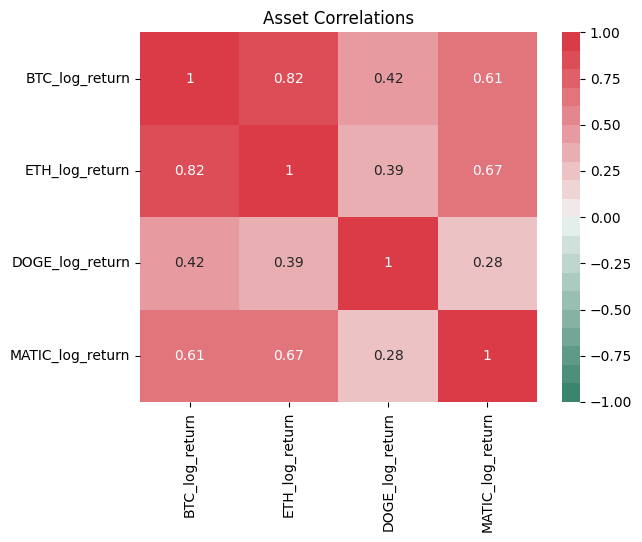

In [4]:
corr = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]].corr()
sns.heatmap(corr, cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

Here, we observe that `DOGE` has the weakest correlation with the other crypto assets. We want to select assets with low correlation to reap the benefits from diversification. If we use assets with very high correlation (e.g. 0.9), there will barely be any diversification benefits and we may run into issues in subsequent optimization.

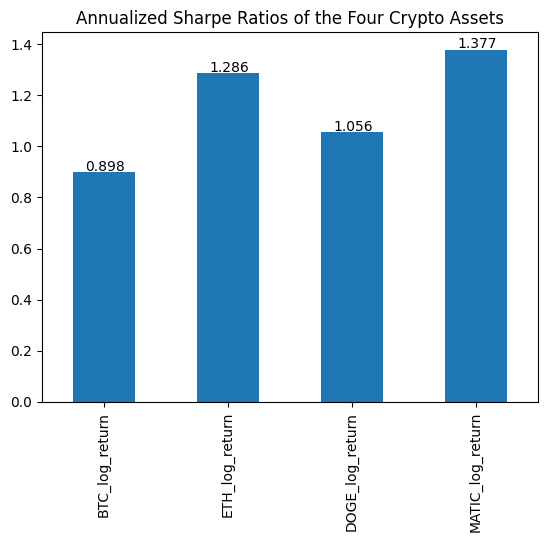

In [5]:
df_return = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
mean_daily_returns = df_return.mean()
std_daily_returns = df_return.std()

annualized_mean_returns = mean_daily_returns * 365
annualized_std_returns = std_daily_returns * np.sqrt(365)
sharpe_ratios = round((annualized_mean_returns) / annualized_std_returns, 3)

# Plot the bar chart
ax = sharpe_ratios.plot(kind='bar', title='Annualized Sharpe Ratios of the Four Crypto Assets')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/5, p.get_height() * 1.005))

All assets in the portfolio are positively correlated, heavily exposing the portfolio to a single factor or market condition. 

Looking at the bar chart, it is evident that `MATIC` has the highest Sharpe Ratio of 1.377 (rounded to 3 decimal places), followed by `ETH` which has a Sharpe Ratio of 1.286. `DOGE` has a Sharpe Ratio of 1.056, while `BTC` has the lowest Sharpe Ratio of 0.898.

The Sharpe ratio is a measure of risk-adjusted return, and a higher value implies that an investment is generating higher returns relative to the risk taken on. Therefore, the statement implies that `MATIC` has the highest risk-adjusted return among the four cryptocurrencies, followed by `ETH`, `DOGE`, and finally `BTC`.

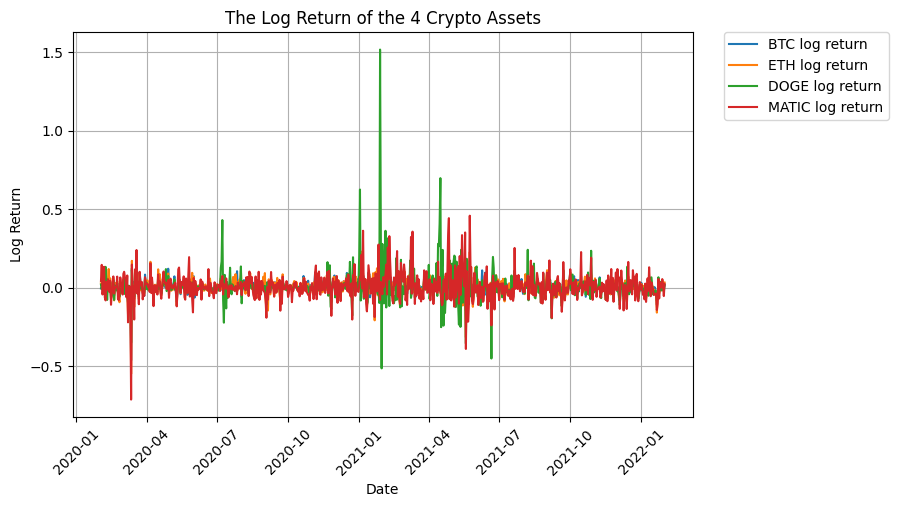

In [6]:
plt.figure(figsize=(8,5))
for col in ["BTC", "ETH", "DOGE", "MATIC"]:
    plt.plot(df[col+"_log_return"], label=(col+' log return'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('The Log Return of the 4 Crypto Assets')
plt.show()

## Question 2

In order to compute the varying weights for each stock in each day, we decided to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the weight of each asset for today.

In [7]:
import cvxpy as cvx

In [8]:
# shifted 1 year earlier than the problem's specified date
start_date = "2019-02-01"
end_date = "2022-02-02"

df2 = get_data_for_multiple_stocks(tickers, start_date, end_date)
df2.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2019-02-02,3521.060791,110.430260,0.001936,0.0,0.009449,0.025873,0.010384,0.0
2019-02-03,3464.013428,107.492668,0.001904,0.0,-0.016334,-0.026962,-0.016667,0.0
2019-02-04,3459.154053,107.821602,0.001896,0.0,-0.001404,0.003055,-0.004211,0.0
2019-02-05,3466.357422,107.443520,0.001888,0.0,0.002080,-0.003513,-0.004228,0.0
2019-02-06,3413.767822,104.919289,0.001866,0.0,-0.015288,-0.023774,-0.011721,0.0


In [9]:
df_return = df2[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
simple_returns = np.exp(df_return) -1
simple_returns.rename(columns={"BTC_log_return": "BTC_return", \
                   "ETH_log_return": "ETH_return", \
                    "DOGE_log_return": "DOGE_return", \
                    "MATIC_log_return": "MATIC_return"}, inplace=True)
simple_returns

,BTC_return,ETH_return,DOGE_return,MATIC_return
Date,,,,
2019-02-02,0.009494,0.026210,0.010438,0.000000
2019-02-03,-0.016202,-0.026601,-0.016529,0.000000
2019-02-04,-0.001403,0.003060,-0.004202,0.000000
2019-02-05,0.002082,-0.003507,-0.004219,0.000000
2019-02-06,-0.015171,-0.023494,-0.011653,0.000000
...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995
2022-01-29,0.009365,0.019627,0.009883,0.009378
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883


### Standard Optimization using `cvxpy`

We will set the following constraints:
1. Long Only
2. Sum of weights = 1 (Leverage of 1)
3. Risk management, single stock allocation has to be less than or equal to 50%

In [10]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    
    log_returns_df = np.log(returns_df+1)
    
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return

    total_simple_return = np.exp(total_return_log) -1
    # print(total_simple_return)
    frequency = 365 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
    # print("geometric return")
    # print(expected_mean)
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))

    ## Important here: --------------------------------------------------------------------------------
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)

    ## Important ends -----------------------------------------------------------------------------------
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()

    return x.value

def compute_log_portfolio_returns(returns, weights_df):

    weighted_returns = pd.DataFrame(returns.values * weights_df.values, columns=returns.columns, index=returns.index)
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns + 1)
    
    return log_returns

### Portfolio 1: Only Minimize Risk, Limit Maximum Holdings to 0.5

In [11]:
weights_df = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=0.5)
        weights_df.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df.loc[date] = np.NaN

In [12]:
weights_df.dropna(inplace=True)
weights_lim_holdings_df = deepcopy(weights_df)
weights_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4643,-0.0000,0.5000,0.0357
2020-02-03,0.4644,-0.0000,0.5000,0.0356
2020-02-04,0.4642,-0.0000,0.5000,0.0358
2020-02-05,0.4641,-0.0000,0.5000,0.0359
2020-02-06,0.4637,-0.0000,0.5000,0.0363
...,...,...,...,...
2022-01-28,0.5000,0.5000,0.0000,0.0000
2022-01-29,0.5000,0.4651,0.0349,-0.0000
2022-01-30,0.5000,0.4613,0.0387,-0.0000
2022-01-31,0.5000,0.4590,0.0410,-0.0000


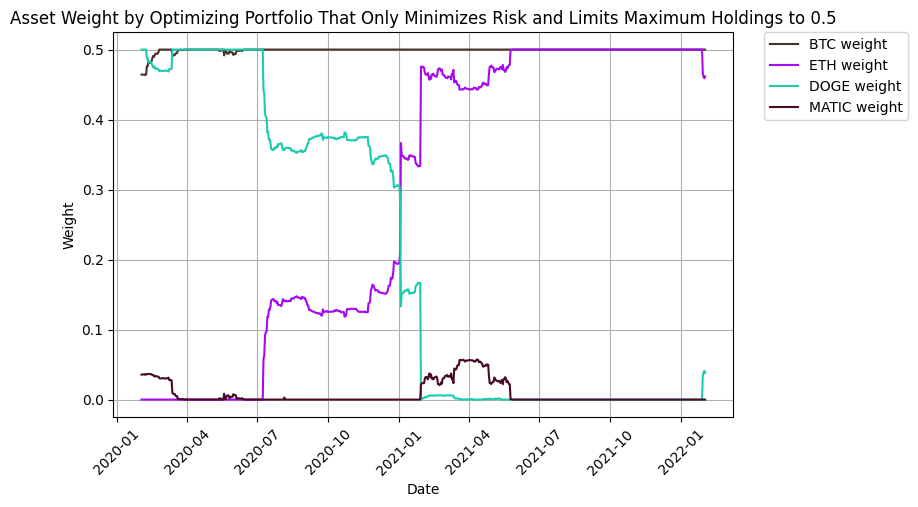

In [13]:
plt.figure(figsize=(8,5))
for col in weights_lim_holdings_df.columns:
    plt.plot(weights_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk and Limits Maximum Holdings to 0.5')
plt.show()

In [14]:
BTC_final_w = weights_lim_holdings_df.tail(1)['BTC'][0]
ETH_final_w = weights_lim_holdings_df.tail(1)['ETH'][0]
DOGE_final_w = weights_lim_holdings_df.tail(1)['DOGE'][0]
MATIC_final_w = weights_lim_holdings_df.tail(1)['MATIC'][0]

print(f'The weights for the 4 crypto assets at the final day are:\nBTC: {BTC_final_w}\nETH: {ETH_final_w}\nDOGE: {DOGE_final_w}\nMATIC: {MATIC_final_w}')

The weights for the 4 crypto assets at the final day are:
BTC: 0.5
ETH: 0.4616
DOGE: 0.0384
MATIC: -0.0


### Portfolio 2: Only Minimize Risk, Do Not Limit Maximum Holdings

In [15]:
weights_df2 = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=1)
        weights_df2.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df2.loc[date] = np.NaN   

In [16]:
weights_df2.dropna(inplace=True)
weights_no_lim_holdings_df = deepcopy(weights_df2)
weights_no_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4498,0.0,0.5148,0.0353
2020-02-03,0.4503,0.0,0.5145,0.0352
2020-02-04,0.4503,0.0,0.5143,0.0354
2020-02-05,0.4506,0.0,0.5139,0.0355
2020-02-06,0.4490,0.0,0.5151,0.0359
...,...,...,...,...
2022-01-28,1.0000,0.0,-0.0000,0.0000
2022-01-29,0.9929,-0.0,0.0071,-0.0000
2022-01-30,0.9904,-0.0,0.0096,-0.0000
2022-01-31,0.9897,-0.0,0.0103,-0.0000


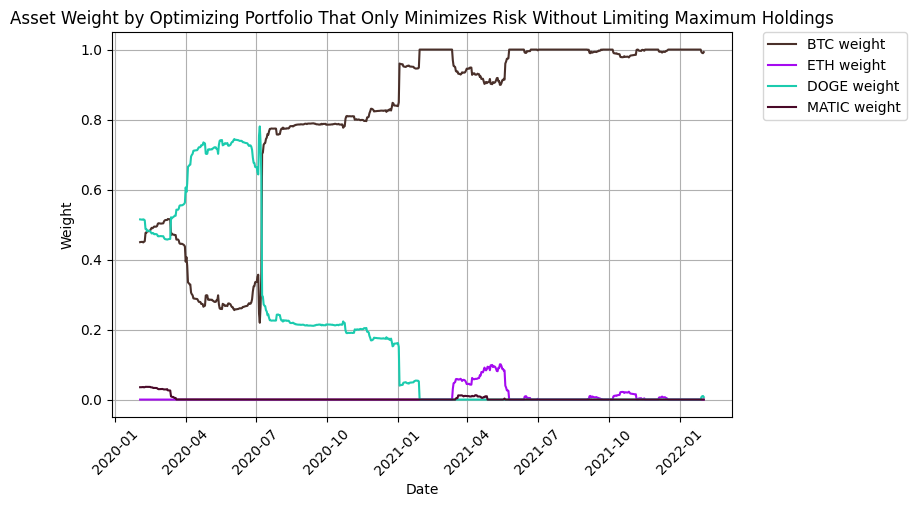

In [17]:
plt.figure(figsize=(8,5))
for col in weights_no_lim_holdings_df.columns:
    plt.plot(weights_no_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk Without Limiting Maximum Holdings')
plt.show()

In [18]:
BTC_final_w2 = weights_no_lim_holdings_df.tail(1)['BTC'][0]
ETH_final_w2 = weights_no_lim_holdings_df.tail(1)['ETH'][0]
DOGE_final_w2 = weights_no_lim_holdings_df.tail(1)['DOGE'][0]
MATIC_final_w2 = weights_no_lim_holdings_df.tail(1)['MATIC'][0]

print(f'The weights for the 4 crypto assets at the final day are:\nBTC: {BTC_final_w2}\nETH: {ETH_final_w2}\nDOGE: {DOGE_final_w2}\nMATIC: {MATIC_final_w2}')

The weights for the 4 crypto assets at the final day are:
BTC: 0.9928
ETH: -0.0
DOGE: 0.0072
MATIC: -0.0


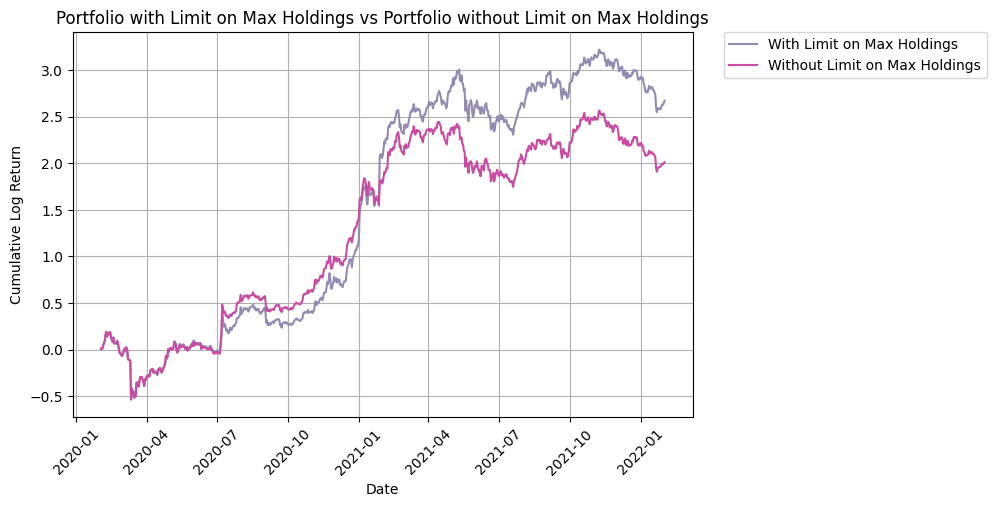

In [19]:
portfolio1 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_lim_holdings_df)
portfolio2 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_no_lim_holdings_df)
all_portfolio_returns = pd.concat([portfolio1, portfolio2], axis = 1)
all_portfolio_returns.columns = ["With Limit on Max Holdings", "Without Limit on Max Holdings"]

plt.figure(figsize=(8,5))
for col in all_portfolio_returns.columns:
    rgb = np.random.rand(3,)
    plt.plot(all_portfolio_returns[col].expanding(0).apply(lambda x: sum(x), raw = True), c=rgb, label=(col))

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Portfolio with Limit on Max Holdings vs Portfolio without Limit on Max Holdings')
plt.show()

In [20]:
cumulative_return_wl = all_portfolio_returns['With Limit on Max Holdings'].sum()
cumulative_return = all_portfolio_returns['Without Limit on Max Holdings'].sum()
annualized_return_wl = np.exp(cumulative_return_wl * (365 / len(all_portfolio_returns))) - 1
annualized_return = np.exp(cumulative_return * (365 / len(all_portfolio_returns))) - 1

print(f'Annualized return for the portfolio with limit on maximum holdings is {annualized_return_wl*100:.2f}%')
print(f'Annualized return for the portfolio without limit on maximum holdings is {annualized_return*100:.2f}%')

Annualized return for the portfolio with limit on maximum holdings is 279.22%
Annualized return for the portfolio without limit on maximum holdings is 172.57%


In [21]:
votality_wl = (all_portfolio_returns.std(axis = 0) * 365 ** 0.5)['With Limit on Max Holdings']
votality = (all_portfolio_returns.std(axis = 0) * 365 ** 0.5)['Without Limit on Max Holdings']

print(f'Annualized votality for the portfolio with limit on maximum holdings is {votality_wl*100:.2f}%')
print(f'Annualized votality for the portfolio without limit on maximum holdings is {votality*100:.2f}%')

Annualized votality for the portfolio with limit on maximum holdings is 92.60%
Annualized votality for the portfolio without limit on maximum holdings is 82.13%


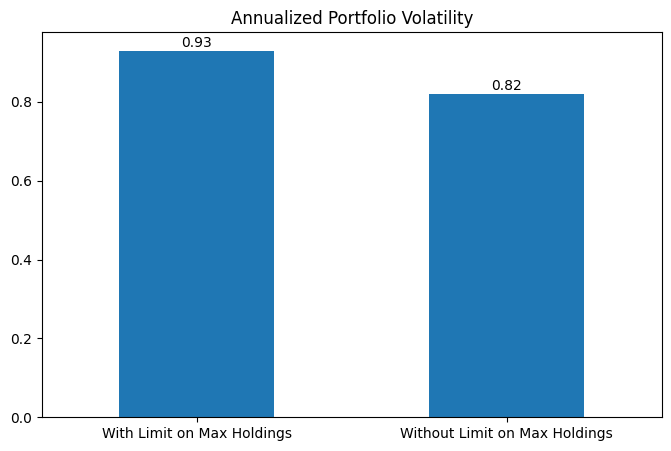

In [22]:
# plot volatility
ax = round(all_portfolio_returns.std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (8, 5))
plt.title("Annualized Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.20, p.get_height() + 0.01))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()

The portfolio with a limit on max holdings is able to obtain a higher cumulative return but at the cost of a higher volatility. 

## Question 3

Similarly, in order to compute the VaR and ES curve, we have to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the VaR and ES for today.

We use Historical Simulation method to estimate VaR and ES.

In [23]:
all_simple_return_df = deepcopy(simple_returns)
all_simple_return_df["Portfolio2_return"] = np.exp(portfolio2) - 1
all_simple_return_df.dropna(inplace=True)
all_simple_return_df

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return
Date,,,,,
2020-02-02,-0.005165,0.026915,0.018993,0.042769,0.008964
2020-02-03,-0.005441,0.006614,-0.011345,0.155428,-0.002816
2020-02-04,-0.012112,-0.003236,0.025820,-0.043331,0.006291
2020-02-05,0.047104,0.079152,0.031562,0.014388,0.037956
2020-02-06,0.012106,0.039704,0.027498,0.141184,0.024668
...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969


In [24]:
df_VaR_HS = deepcopy(all_simple_return_df)

for i in range(0, len(df_VaR_HS)):
    for j in range(len(all_simple_return_df.columns)):
        past_365 = df_VaR_HS.iloc[(i-365):(i), j]
        past_365.dropna(inplace=True)
        if len(past_365) == 365:
            VaR = past_365.quantile(0.05) # VaR of 95%
            log_returns_sorted = sorted(past_365.dropna())
            length = len(log_returns_sorted)

            cutoff_rt_index = math.floor(length*0.05 +1) - 1
                
            sum_rt = sum(log_returns_sorted[:cutoff_rt_index])

            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = VaR
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = sum_rt/len(log_returns_sorted[:cutoff_rt_index])
        else:
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = np.NaN
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = np.NaN


In [25]:
df_VaR_HS.dropna(inplace=True)
df_old_HS = deepcopy(df_VaR_HS)
df_VaR_HS = df_VaR_HS.loc["2020-02-01":]
df_VaR_HS

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return,BTC_return_VaR_95,BTC_return_ES_95,ETH_return_VaR_95,ETH_return_ES_95,DOGE_return_VaR_95,DOGE_return_ES_95,MATIC_return_VaR_95,MATIC_return_ES_95,Portfolio2_return_VaR_95,Portfolio2_return_ES_95
Date,,,,,,,,,,,,,,,
2021-02-01,0.012768,0.041106,-0.062399,0.067870,0.012768,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-02,0.058834,0.106756,-0.096201,0.005040,0.058834,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-03,0.055246,0.096170,0.177665,0.067011,0.055246,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-04,-0.014571,-0.039826,0.435587,0.080094,-0.014571,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-05,0.032991,0.077684,-0.119237,0.156715,0.032991,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000


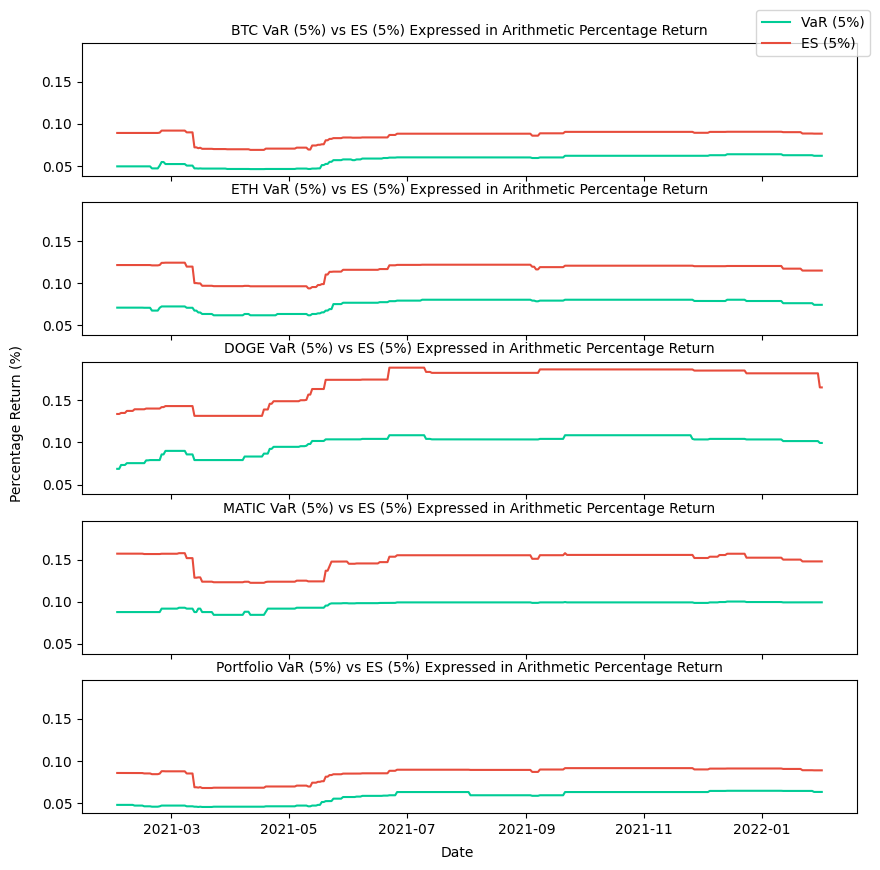

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True, sharey=True)
ax1, ax2, ax3, ax4, ax5 = axes.flatten()
var_col = "#00CC96"
es_col = "#E74C3C"

var1, = ax1.plot(-df_VaR_HS['BTC_return_VaR_95'], c=var_col)
es1, = ax1.plot(-df_VaR_HS['BTC_return_ES_95'], c=es_col)
ax1.set_title('BTC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax1.title.set_size(10)

var2, = ax2.plot(-df_VaR_HS['ETH_return_VaR_95'], c=var_col)
es2, = ax2.plot(-df_VaR_HS['ETH_return_ES_95'], c=es_col)
ax2.set_title('ETH VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax2.title.set_size(10)

var3, = ax3.plot(-df_VaR_HS['DOGE_return_VaR_95'], c=var_col)
es3, = ax3.plot(-df_VaR_HS['DOGE_return_ES_95'], c=es_col)
ax3.set_title('DOGE VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax3.title.set_size(10)

var4, = ax4.plot(-df_VaR_HS['MATIC_return_VaR_95'], c=var_col)
es4, = ax4.plot(-df_VaR_HS['MATIC_return_ES_95'], c=es_col)
ax4.set_title('MATIC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax4.title.set_size(10)

var5, = ax5.plot(-df_VaR_HS['Portfolio2_return_VaR_95'], c=var_col)
es5, = ax5.plot(-df_VaR_HS['Portfolio2_return_ES_95'], c=es_col)
ax5.set_title('Portfolio VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax5.title.set_size(10)

fig.legend((var5, es5), ('VaR (5%)', 'ES (5%)'), loc='upper right', bbox_to_anchor=[0.92, 0.92])

# Set common labels
fig.text(0.5, 0.07, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Percentage Return (%)', ha='center', va='center', rotation='vertical')

plt.show()


DOGE is the riskiest component in the portfolio as it has the highest VaR and ES value among all 4 assets. 

## Question 4

In [27]:
options_df = df2['2020-02-01':][['BTC_close','ETH_close']].copy()
options_df['BTC_daily_logreturns'] = np.log(options_df['BTC_close'] / options_df['BTC_close'].shift(1))
options_df['ETH_daily_logreturns'] = np.log(options_df['ETH_close'] / options_df['ETH_close'].shift(1))
btc_upside_std_dev = np.std(options_df.loc[options_df['BTC_daily_logreturns'] >= 0]['BTC_daily_logreturns'])
btc_downside_std_dev = np.std(options_df.loc[options_df['BTC_daily_logreturns'] < 0]['BTC_daily_logreturns'])
eth_upside_std_dev = np.std(options_df.loc[options_df['ETH_daily_logreturns'] >= 0]['ETH_daily_logreturns'])
eth_downside_std_dev = np.std(options_df.loc[options_df['ETH_daily_logreturns'] < 0]['ETH_daily_logreturns'])
print(f'Bitcoin - standard deviation of positive daily returns: {btc_upside_std_dev*100:.3f}%')
print(f'Bitcoin - standard deviation of negative daily returns: {btc_downside_std_dev*100:.3f}%')
print(f'Ethereum - standard deviation of positive daily returns: {eth_upside_std_dev*100:.3f}%')
print(f'Ethereum - standard deviation of negative daily returns: {eth_downside_std_dev*100:.3f}%')

Bitcoin - standard deviation of positive daily returns: 2.647%
Bitcoin - standard deviation of negative daily returns: 3.538%
Ethereum - standard deviation of positive daily returns: 3.341%
Ethereum - standard deviation of negative daily returns: 4.671%


In [28]:
btc_std_dev = np.std(options_df['BTC_daily_logreturns'])
eth_std_dev = np.std(options_df['ETH_daily_logreturns'])
print(f'Bitcoin - standard deviation of daily returns: {btc_std_dev*100:.3f}%')
print(f'Ethereum - standard deviation of daily returns: {eth_std_dev*100:.3f}%')

Bitcoin - standard deviation of daily returns: 4.106%
Ethereum - standard deviation of daily returns: 5.453%


In [29]:
risk_free_rate = 0.02
btc_returns = options_df['BTC_daily_logreturns']
btc_positive_returns = options_df.loc[options_df['BTC_daily_logreturns'] > 0]['BTC_daily_logreturns']
btc_negative_returns = options_df.loc[options_df['BTC_daily_logreturns'] < 0]['BTC_daily_logreturns']
btc_upr = np.mean(np.exp(btc_positive_returns)-1)/np.abs(np.mean(np.exp(btc_negative_returns)-1))
print("BTC's Upside Potential Ratio is ", btc_upr)
btc_returns_lower_than_risk_free_rate = options_df.loc[options_df['BTC_daily_logreturns'] < risk_free_rate]['BTC_daily_logreturns']
btc_dr = np.sqrt(np.mean(np.square(np.exp(btc_returns_lower_than_risk_free_rate)-1)))
print("BTC's Downside Risk is ", btc_dr)

eth_returns = options_df['ETH_daily_logreturns']
eth_positive_returns = options_df.loc[options_df['ETH_daily_logreturns'] > 0]['ETH_daily_logreturns']
eth_negative_returns = options_df.loc[options_df['ETH_daily_logreturns'] < 0]['ETH_daily_logreturns']
eth_upr = np.mean(np.exp(eth_positive_returns)-1)/np.abs(np.mean(np.exp(eth_negative_returns)-1))
print("ETH's Upside Potential Ratio is ", eth_upr)
eth_returns_lower_than_risk_free_rate = options_df.loc[options_df['ETH_daily_logreturns'] < risk_free_rate]['ETH_daily_logreturns']
eth_dr = np.sqrt(np.mean(np.square(np.exp(eth_returns_lower_than_risk_free_rate)-1)))
print("ETH's Downside Risk is ", eth_dr)

BTC's Upside Potential Ratio is  1.0677228961544065
BTC's Downside Risk is  0.03284238166447738
ETH's Upside Potential Ratio is  1.0525071575334253
ETH's Downside Risk is  0.04501305223991862


Gains for ETH are more volatile (volatility of 3.341% for positive daily returns) than gains for BTC (lower volatility of 2.647% for positive daily returns). ETH also has a higher volatility of 4.671% for negative daily returns compared to BTC's volatility of 3.538% for negative daily returns.

In addition, an Upside potential ratio (UPR) is the ratio of potential gain vs potential loss. A UPR of 1 means that potential gain and potential loss are equal, while a UPR greater than 1 means that potential gain is higher than potential loss.

Downside Risk (DR) indicates the likelihood of returns falling below the risk-free rate.

ETH has a lower upside potential ratio and a higher downside risk and thus, ETH's prices are more volatile.

In [30]:
ethpriceatbuyingoptions = float(options_df.loc['2021-01-01']['ETH_close'])
ethpriceatbuyingoptions = round(ethpriceatbuyingoptions, 2)
ethcallprice = ethpriceatbuyingoptions*(1+eth_upside_std_dev)
ethcallprice = round(ethcallprice, 2)
ethputprice = ethpriceatbuyingoptions*(1-eth_downside_std_dev)
ethputprice = round(ethputprice, 2)
print(f'Price of ETH on 2021-01-01: {ethpriceatbuyingoptions}USD')
print(f'+1 postive returns standard deviation strike price: {ethcallprice}USD')
print(f'-1 negative returns standard deviation strike price: {ethputprice}USD')

Price of ETH on 2021-01-01: 730.37USD
+1 postive returns standard deviation strike price: 754.77USD
-1 negative returns standard deviation strike price: 696.25USD


In [31]:
options = pd.read_csv('OKEx_options_trade.csv')
options.drop(options.index[0], inplace=True)
options = options.drop(columns=['Unnamed: 0'])
options = options[pd.to_numeric(options['qty'], errors='coerce').notnull()]
options['exercise_date'] = options['instrument_id'].str.extract(r'(\d{6})')
options['exercise_date'] = pd.to_datetime(options['exercise_date'], format='%y%m%d')
options['strike_price'] = options['instrument_id'].str.extract(r'-(\d+)-[A-Z]')
options['coin_type'] = options['instrument_id'].str.split('-', n=1).str[0]
options['option_type'] = options['instrument_id'].str[-1]
options = options.sort_values(by='exercise_date')
options.head()

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type
128,sell,68,0.01,4,BTC-USD-200207-10000-C,2020-02-01T07:04:52.544Z,2020-02-07,10000,BTC,C
150,buy,59,0.024,20,BTC-USD-200207-9500-C,2020-02-01T08:31:30.077Z,2020-02-07,9500,BTC,C
151,buy,60,0.024,100,BTC-USD-200207-9500-C,2020-02-01T08:31:38.836Z,2020-02-07,9500,BTC,C
152,buy,61,0.024,100,BTC-USD-200207-9500-C,2020-02-01T08:31:43.632Z,2020-02-07,9500,BTC,C
153,buy,62,0.024,85,BTC-USD-200207-9500-C,2020-02-01T08:31:47.593Z,2020-02-07,9500,BTC,C


Given that we can choose exercise prices as close to minus/plus one standard deviation of the asset return, we see that our range of exercise prices has upper and lower bounds that are about equidistant from the price of ETH on 2021-01-01. Therefore, we will choose to buy options as close to the asset price (in the middle) as possible.

### Calls To Buy

In [32]:
putstobuy = options.loc[(options['exercise_date']=='2021-01-08') & (options['coin_type']=='ETH') & (options['option_type']=='P')]
callstobuy = options.loc[(options['exercise_date']=='2021-01-08') & (options['coin_type']=='ETH') & (options['option_type']=='C')]

strikeprice = ethpriceatbuyingoptions
diff = strikeprice - callstobuy['strike_price'].astype(int)
callcandidates = deepcopy(callstobuy)
callcandidates['abs_diff'] = diff.abs()
callcandidates = callcandidates.sort_values('abs_diff', ascending=True)
idealsp = int(callcandidates.iloc[0]['strike_price'])
callcandidates = callcandidates.loc[callcandidates['strike_price'].astype(int) == idealsp]
callcandidates = callcandidates.sort_values('price', ascending=True)
callcandidates.head(20)

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type,abs_diff
78326,sell,43,0.0375,2,ETH-USD-210108-740-C,2021-01-01T19:05:19.309Z,2021-01-08,740,ETH,C,9.63
77825,sell,39,0.038,18,ETH-USD-210108-740-C,2021-01-01T18:55:49.064Z,2021-01-08,740,ETH,C,9.63
77826,sell,40,0.038,20,ETH-USD-210108-740-C,2021-01-01T18:56:27.892Z,2021-01-08,740,ETH,C,9.63
78325,sell,42,0.0385,15,ETH-USD-210108-740-C,2021-01-01T19:02:16.621Z,2021-01-08,740,ETH,C,9.63
78136,sell,41,0.039,20,ETH-USD-210108-740-C,2021-01-01T18:56:49.072Z,2021-01-08,740,ETH,C,9.63
77827,sell,41,0.039,20,ETH-USD-210108-740-C,2021-01-01T18:56:49.072Z,2021-01-08,740,ETH,C,9.63
73090,sell,35,0.0575,10,ETH-USD-210108-740-C,2020-12-31T21:34:22.471Z,2021-01-08,740,ETH,C,9.63
73671,sell,35,0.0575,10,ETH-USD-210108-740-C,2020-12-31T21:34:22.471Z,2021-01-08,740,ETH,C,9.63
73905,sell,36,0.0585,5,ETH-USD-210108-740-C,2021-01-01T01:36:23.707Z,2021-01-08,740,ETH,C,9.63
73906,sell,37,0.059,5,ETH-USD-210108-740-C,2021-01-01T01:36:38.036Z,2021-01-08,740,ETH,C,9.63


### Puts To Buy

In [33]:
putdiff = strikeprice - putstobuy['strike_price'].astype(int)
putcandidates = deepcopy(putstobuy)
putcandidates['abs_diff'] = putdiff.abs()
putcandidates = putcandidates.sort_values('abs_diff', ascending=True)
idealsp = int(callcandidates.iloc[0]['strike_price'])
putcandidates = putcandidates.loc[putcandidates['strike_price'].astype(int) == idealsp]
putcandidates = putcandidates.sort_values('price', ascending=True)
putcandidates.head(20)

,side,trade_id,price,qty,instrument_id,timestamp,exercise_date,strike_price,coin_type,option_type,abs_diff
76250,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
74934,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
78179,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
77656,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
74593,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
76755,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
75640,buy,4,0.0535,12,ETH-USD-210108-740-P,2021-01-01T06:33:43.289Z,2021-01-08,740,ETH,P,9.63
73720,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,9.63
73120,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,9.63
74363,sell,3,0.061,1,ETH-USD-210108-740-P,2020-12-31T01:46:03.963Z,2021-01-08,740,ETH,P,9.63


### Modifications to the no limit setting portfolio from Q2

In [34]:
ethweightatpurchase = weights_no_lim_holdings_df.loc['2021-01-01']['ETH']
print(f'Weight of ETH in our no limit setting portfolio on 2021-01-01: {ethweightatpurchase}')

Weight of ETH in our no limit setting portfolio on 2021-01-01: -0.0


We have earlier idenfied that ETH is the more volatile coin compared to BTC, however our no limit setting portfolio from Question 2 does not hold any ETH on 2021-01-01. Thus, we will modify our no limit setting portfolio to a portfolio only holding **BTC** and **ETH** for the two year duration from 2020-02-01 to 2022-02-01 and place some emphasis on maximizing returns (as we previously did not) as a means to penalize extreme weights that are very close to one (with no hard set maximum weight limit).

In [35]:
weights_df3 = pd.DataFrame(columns=['BTC', 'ETH'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)][['BTC_return','ETH_return']]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0.5, max_holding=1)
        weights_df3.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df3.loc[date] = np.NaN

In [36]:
weights_df3.dropna(inplace=True)
mod_weights_no_lim_holdings_df = deepcopy(weights_df3)
newethweightatpurchase = mod_weights_no_lim_holdings_df.loc['2021-01-01']['ETH']
newbtcweightatpurchase = mod_weights_no_lim_holdings_df.loc['2021-01-01']['BTC']
print(f'Weight of BTC and ETH in our modified no limit setting portfolio on 2021-01-01 are: {newbtcweightatpurchase}, {newethweightatpurchase} respectively')

Weight of BTC and ETH in our modified no limit setting portfolio on 2021-01-01 are: 0.8768, 0.1232 respectively


In [37]:
latest_prices = df2[['ETH_close', 'BTC_close']].loc['2021-01-01']
latest_prices.index = ['ETH', 'BTC']
latest_prices.sort_index(inplace=True)
print(f'The latest prices for BTC and ETH are {latest_prices["BTC"]}, {latest_prices["ETH"]} respectively')

The latest prices for BTC and ETH are 29374.15234375, 730.3675537109375 respectively


### Important Assumption: Fractional Share Investment

In order to fully utilize all the funds and show the maximum potential return of using One-off Straddle, we assumed that **fractional share investment** is allowed, i.e. investors are able to buy less than a full share of stock. We also assumed that there is no any arbitrary minimum investment amount and the transaction cost is **zero**. 

Now, let assume that initially we have a principal of **100000 USD**. 

In [38]:
df_btceth = df2.loc['2020-02-02':][['BTC_close', 'ETH_close']]
INITIAL_FUND = 100000
df_btceth.loc['2020-02-02', 'BTC_units'] = INITIAL_FUND * weights_df3.loc['2020-02-02', 'BTC'] / df_btceth.loc['2020-02-02', 'BTC_close']
df_btceth.loc['2020-02-02', 'ETH_units'] = INITIAL_FUND * weights_df3.loc['2020-02-02', 'ETH'] / df_btceth.loc['2020-02-02', 'ETH_close']
df_btceth.loc['2020-02-02', 'Portfolio_Val'] = df_btceth.loc['2020-02-02', 'BTC_units'] * df_btceth.loc['2020-02-02', 'BTC_close'] + df_btceth.loc['2020-02-02', 'ETH_units'] * df_btceth.loc['2020-02-02', 'ETH_close']

In [39]:
for i in range(1, len(weights_df3)):
    portfolio_worth_nextday = df_btceth.iloc[i-1, 2] * df_btceth.iloc[i, 0] + df_btceth.iloc[i-1, 3] * df_btceth.iloc[i, 1]
    investment_BTC = portfolio_worth_nextday * weights_df3.iloc[i, 0]
    investment_ETH = portfolio_worth_nextday * weights_df3.iloc[i, 1]
    df_btceth.iloc[i, 2] = investment_BTC / df_btceth.iloc[i, 0]
    df_btceth.iloc[i, 3] = investment_ETH / df_btceth.iloc[i, 1]
    df_btceth.iloc[i, 4] = df_btceth.iloc[i, 2] * df_btceth.iloc[i, 0] + df_btceth.iloc[i, 3] * df_btceth.iloc[i, 1]

In [40]:
df_btceth

,BTC_close,ETH_close,BTC_units,ETH_units,Portfolio_Val
Date,,,,,
2020-02-02,9344.365234,188.617538,10.701636,0.000000,100000.000000
2020-02-03,9293.521484,189.865067,10.701636,0.000000,99455.888670
2020-02-04,9180.962891,189.250595,10.701636,0.000000,98251.327515
2020-02-05,9613.423828,204.230240,10.701636,0.000000,102879.367266
2020-02-06,9729.801758,212.339081,10.701636,0.000000,104124.801565
...,...,...,...,...,...
2022-01-28,37784.332031,2547.092041,10.665089,56.690538,547369.285120
2022-01-29,38138.179688,2597.084717,10.212899,63.330947,553977.213574
2022-01-30,37917.601562,2603.466553,10.246770,62.837648,552128.639166


In [41]:
portvalatstart = df_btceth.loc['2021-01-01']['Portfolio_Val']
print(f'Our portfolio on 2021-01-01 would be worth {portvalatstart:.2f}USD.')
print(f'Our portfolio on 2021-01-01 will place a weight of {newethweightatpurchase} on ETH.')
ethvalueatstart = portvalatstart*newethweightatpurchase
num_eth = ethvalueatstart/ethpriceatbuyingoptions
num_options = round(num_eth)
print(f'Our portfolio on 2021-01-01 would therefore contain {ethvalueatstart:.2f}USD worth of ETH.')
print(f'We would be holding {num_eth:.3f} ETH.')
print(f'Rounding to the nearest integer, we would therefore buy {num_options} calls and puts each on 2021-01-01 (rounded to nearest integer).')

Our portfolio on 2021-01-01 would be worth 290854.51USD.
Our portfolio on 2021-01-01 will place a weight of 0.1232 on ETH.
Our portfolio on 2021-01-01 would therefore contain 35833.28USD worth of ETH.
We would be holding 49.062 ETH.
Rounding to the nearest integer, we would therefore buy 49 calls and puts each on 2021-01-01 (rounded to nearest integer).


We assumed that we are the buyers that placed options' orders in the options orderbook that are shown in the `OKEx_options_trade.csv`. Hence, we shall filter the datapoints which have `side == Buy`. 

In [42]:
callcandidates_buy = callcandidates[callcandidates['side'] == 'buy']
putcandidates_buy = putcandidates[putcandidates['side'] == 'buy']

In [43]:
cquantityleft = num_options
pquantityleft = num_options
calloption_cost_eth = 0
putoption_cost_eth = 0
callids = {}
putids = {}

counter = 0
while (cquantityleft > 0):
    call = callcandidates_buy.iloc[counter]
    rowid = callcandidates_buy.iloc[counter].name
    price = float(call['price'])
    quantity = int(call['qty'])
    tradeid = call['instrument_id']
    timestamp = call['timestamp']
    if (quantity > cquantityleft):
        calloption_cost_eth += (cquantityleft*price)
        callids[rowid] = [cquantityleft,price,tradeid,timestamp]
        cquantityleft = 0
    else:
        calloption_cost_eth += (quantity*price)
        cquantityleft -= quantity
        callids[rowid] = [quantity,price,tradeid,timestamp]
        counter += 1

counter = 0
while (pquantityleft > 0):
    put = putcandidates_buy.iloc[counter]
    rowid = putcandidates_buy.iloc[counter].name
    price = float(put['price'])
    quantity = int(put['qty'])
    tradeid = put['instrument_id']
    timestamp = put['timestamp']
    if (quantity > pquantityleft):
        putoption_cost_eth += (pquantityleft*price)
        putids[rowid] = [pquantityleft,price,tradeid,timestamp]
        pquantityleft = 0
    else:
        putoption_cost_eth += (quantity*price)
        pquantityleft -= quantity
        putids[rowid] = [quantity,price,tradeid,timestamp]
        counter += 1

print('The calls we would buy are: ')
for rowid in callids:
    call = callids[rowid]
    print(f'Row {rowid}: Quantity: {call[0]} | Price: {call[1]} | Instrument ID: {call[2]} | Timestamp: {call[3]})')

print('The puts we would buy are: ')
for rowid in putids:
    put = putids[rowid]
    print(f'Row {rowid}: Quantity: {put[0]} | Price: {put[1]} | Instrument ID: {put[2]} | Timestamp: {put[3]})')

The calls we would buy are: 
Row 76563: Quantity: 10 | Price: 0.06 | Instrument ID: ETH-USD-210108-740-C | Timestamp: 2021-01-01T01:37:00.336Z)
Row 75568: Quantity: 10 | Price: 0.06 | Instrument ID: ETH-USD-210108-740-C | Timestamp: 2021-01-01T01:37:00.336Z)
Row 76210: Quantity: 10 | Price: 0.06 | Instrument ID: ETH-USD-210108-740-C | Timestamp: 2021-01-01T01:37:00.336Z)
Row 75060: Quantity: 10 | Price: 0.06 | Instrument ID: ETH-USD-210108-740-C | Timestamp: 2021-01-01T01:37:00.336Z)
Row 73910: Quantity: 9 | Price: 0.06 | Instrument ID: ETH-USD-210108-740-C | Timestamp: 2021-01-01T01:37:00.336Z)
The puts we would buy are: 
Row 76250: Quantity: 12 | Price: 0.0535 | Instrument ID: ETH-USD-210108-740-P | Timestamp: 2021-01-01T06:33:43.289Z)
Row 74934: Quantity: 12 | Price: 0.0535 | Instrument ID: ETH-USD-210108-740-P | Timestamp: 2021-01-01T06:33:43.289Z)
Row 78179: Quantity: 12 | Price: 0.0535 | Instrument ID: ETH-USD-210108-740-P | Timestamp: 2021-01-01T06:33:43.289Z)
Row 77656: Quantit

In [44]:
print(f'Price of ETH on 2021-01-01: {ethpriceatbuyingoptions}USD')
ethpriceatexercise = float(options_df.loc['2021-01-08']['ETH_close'])
ethpriceatexercise = round(ethpriceatexercise, 2)
print(f'Price of ETH on 2021-01-08: {ethpriceatexercise}USD')
print(f'Total value of only holding {num_eth:.3f} ETH on 2021-01-08: {ethpriceatexercise*num_eth:.2f}USD')
print(f'Percentage return of only holding our ETH from 2021-01-01 to 2021-01-08: \
{((ethpriceatexercise*num_eth)/(ethpriceatbuyingoptions*num_eth)-1)*100:.2f}%')

option_strikeprice = idealsp
straddle_return = ethpriceatexercise * num_eth + \
max(ethpriceatexercise - option_strikeprice, 0)*num_options + max(option_strikeprice - ethpriceatexercise, 0)*num_options \
- (calloption_cost_eth+putoption_cost_eth)*ethpriceatbuyingoptions

print(f'Price of ETH\'s call options and put options on 2021-01-01: {calloption_cost_eth:.3f}ETH, {putoption_cost_eth:.3f}ETH')
print(f'Total value after exercising both put and call options of ETH on 2021-01-08 (minus cost of options): \
{straddle_return:.2f}USD')
print(f'Percentage return of using straddle strategy on ETH from 2021-01-01 to 2021-01-08: \
{(straddle_return/(ethpriceatbuyingoptions*num_eth)-1)*100:.2f}%')

Price of ETH on 2021-01-01: 730.37USD
Price of ETH on 2021-01-08: 1224.2USD
Total value of only holding 49.062 ETH on 2021-01-08: 60061.47USD
Percentage return of only holding our ETH from 2021-01-01 to 2021-01-08: 67.61%
Price of ETH's call options and put options on 2021-01-01: 2.940ETH, 2.622ETH
Total value after exercising both put and call options of ETH on 2021-01-08 (minus cost of options): 79725.32USD
Percentage return of using straddle strategy on ETH from 2021-01-01 to 2021-01-08: 122.49%


Hence, the percentage return of only holding our ETH from 2021-01-01 to 2021-01-08 is **67.61%** (*2 d.p.*).  
However, if we applied a straddle strategy, the percentage return of using the straddle strategy on ETH from 2021-01-01 to 2021-01-08 can be up to **122.49%** (*2 d.p.*).

Since on 2021-01-01, we used 2.940 and 2.622 units of ETH to buy call options and put options respectively, hence we subtract the premium of a total of 2.940 + 2.622 = 5.562 units of ETH paid from the payoff to obtain the percentage returns (using the price of ETH on 2021-01-01 when buying the options), i.e. the total cost of the options is 5.562*730.37 = 4062.32USD.

In [45]:
eth_returns_after = ethpriceatexercise*num_eth 
with_straddle_returns_after = straddle_return - eth_returns_after
df_btceth['Portfolio_Val_With_Straddle'] = df_btceth['Portfolio_Val']
df_btceth.loc['2021-01-08':, 'Portfolio_Val_With_Straddle'] += with_straddle_returns_after
df_btceth['original_log_return'] = np.log(df_btceth['Portfolio_Val'] / df_btceth['Portfolio_Val'].shift(1))
df_btceth['log_return'] = np.log(df_btceth['Portfolio_Val_With_Straddle'] / df_btceth['Portfolio_Val_With_Straddle'].shift(1))
df_btceth.dropna(inplace=True)

In [46]:
cumulative_return = df_btceth['original_log_return'].sum()
annualized_return = np.exp(cumulative_return * (365 / len(df_btceth))) - 1
cumulative_return_ws = df_btceth['log_return'].sum()
annualized_return_ws = np.exp(cumulative_return_ws * (365 / len(df_btceth))) - 1
print(f'Annualized log return for our portfolio without the one-off straddle is {annualized_return*100:.2f}%')
print(f'Annualized log return for our portfolio with the one-off straddle is {annualized_return_ws*100:.2f}%')

Annualized log return for our portfolio without the one-off straddle is 139.27%
Annualized log return for our portfolio with the one-off straddle is 143.35%


In [47]:
mean_daily_returns = df_btceth['original_log_return'].mean()
std_daily_returns = df_btceth['original_log_return'].std()
mean_daily_returns_ws = df_btceth['log_return'].mean()
std_daily_returns_ws = df_btceth['log_return'].std()

annualized_mean_returns = mean_daily_returns * 365
annualized_std_returns = std_daily_returns * np.sqrt(365)
annualized_mean_returns_ws = mean_daily_returns_ws * 365
annualized_std_returns_ws = std_daily_returns_ws * np.sqrt(365)

sharpe_ratio = round((annualized_mean_returns) / annualized_std_returns, 3)
sharpe_ratio_ws = round((annualized_mean_returns_ws) / annualized_std_returns_ws, 3)
print(f'Annualized Sharpe ratio for our portfolio without the one-off straddle is {sharpe_ratio}.')
print(f'Annualized Sharpe ratio for our portfolio with the one-off straddle is {sharpe_ratio_ws}.')

Annualized Sharpe ratio for our portfolio without the one-off straddle is 1.033.
Annualized Sharpe ratio for our portfolio with the one-off straddle is 1.071.


In [48]:
sharpe_ratio_compare = pd.Series([sharpe_ratio, sharpe_ratio_ws], index=["Without One-off Straddle", "With One-off Straddle"])
sharpe_ratio_compare

Without One-off Straddle    1.033
With One-off Straddle       1.071
dtype: float64

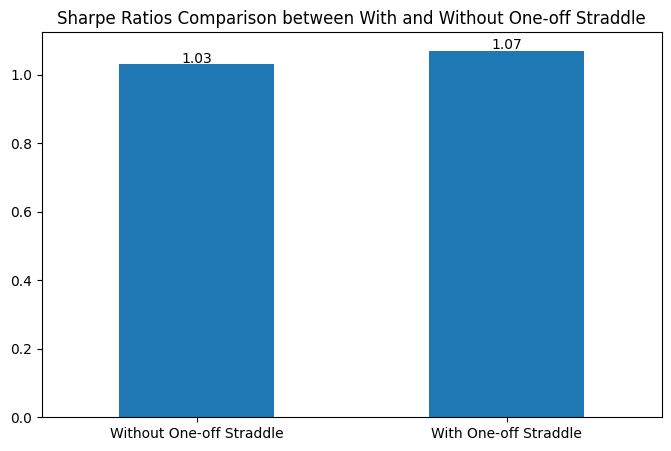

In [49]:
# plot volatility
ax = round(sharpe_ratio_compare, 2).plot(kind="bar", figsize = (8, 5))
plt.title("Sharpe Ratios Comparison between With and Without One-off Straddle")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.20, p.get_height() + 0.005))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()

## Question 5

In [50]:
fig = px.line(df_btceth, y="BTC_close", title='BTC Close Price', labels = {'BTC_close':'BTC Close Price(in USD)'})
fig.show()

In [51]:
fig = px.line(df_btceth, y="ETH_close", title='BTC Close Price', labels = {'ETH_close':'BTC Close Price(in USD)'})
fig.show()

In [52]:
window1 = 28
window2 = 56
df_btceth_ma = deepcopy(df_btceth)
df_btceth_ma['BTC_close_'+str(window1)] = df_btceth_ma['BTC_close'].rolling(window = window1).mean()
df_btceth_ma['BTC_close_'+str(window2)] = df_btceth_ma['BTC_close'].rolling(window = window2).mean()

df_btceth_ma['ETH_close_'+str(window1)] = df_btceth_ma['ETH_close'].rolling(window = window1).mean()
df_btceth_ma['ETH_close_'+str(window2)] = df_btceth_ma['ETH_close'].rolling(window = window2).mean()
df_btceth_ma.dropna(inplace=True)
df_btceth_ma

,BTC_close,ETH_close,BTC_units,ETH_units,Portfolio_Val,Portfolio_Val_With_Straddle,original_log_return,log_return,BTC_close_28,BTC_close_56,ETH_close_28,ETH_close_56
Date,,,,,,,,,,,,
2020-03-29,5922.042969,125.583733,10.701636,0.000000,63375.551150,63375.551150,-0.052650,-0.052650,6841.805682,8226.548506,160.221244,201.014397
2020-03-30,6429.841797,132.904541,10.701636,0.000000,68809.829620,68809.829620,0.082268,0.082268,6754.668963,8175.411368,156.733200,199.997245
2020-03-31,6438.644531,133.593567,10.701636,0.000000,68904.033284,68904.033284,0.001368,0.001368,6670.771048,8126.441398,153.487269,199.003369
2020-04-01,6606.776367,135.634552,10.701636,0.000000,70703.319075,70703.319075,0.025778,0.025778,6594.039987,8072.751264,150.312861,197.778446
2020-04-02,6793.624512,142.029144,10.701636,0.000000,72702.899997,72702.899997,0.027889,0.027889,6512.427909,8020.319528,147.197181,196.522912
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,37784.332031,2547.092041,10.665089,56.690538,547369.285120,567033.132365,0.026218,0.025297,41428.863839,44997.531808,3100.195644,3551.312435
2022-01-29,38138.179688,2597.084717,10.212899,63.330947,553977.213574,573641.060819,0.012000,0.011586,41087.841239,44799.986747,3058.316633,3524.124887
2022-01-30,37917.601562,2603.466553,10.246770,62.837648,552128.639166,571792.486411,-0.003342,-0.003228,40751.140625,44595.500209,3014.527405,3495.645312


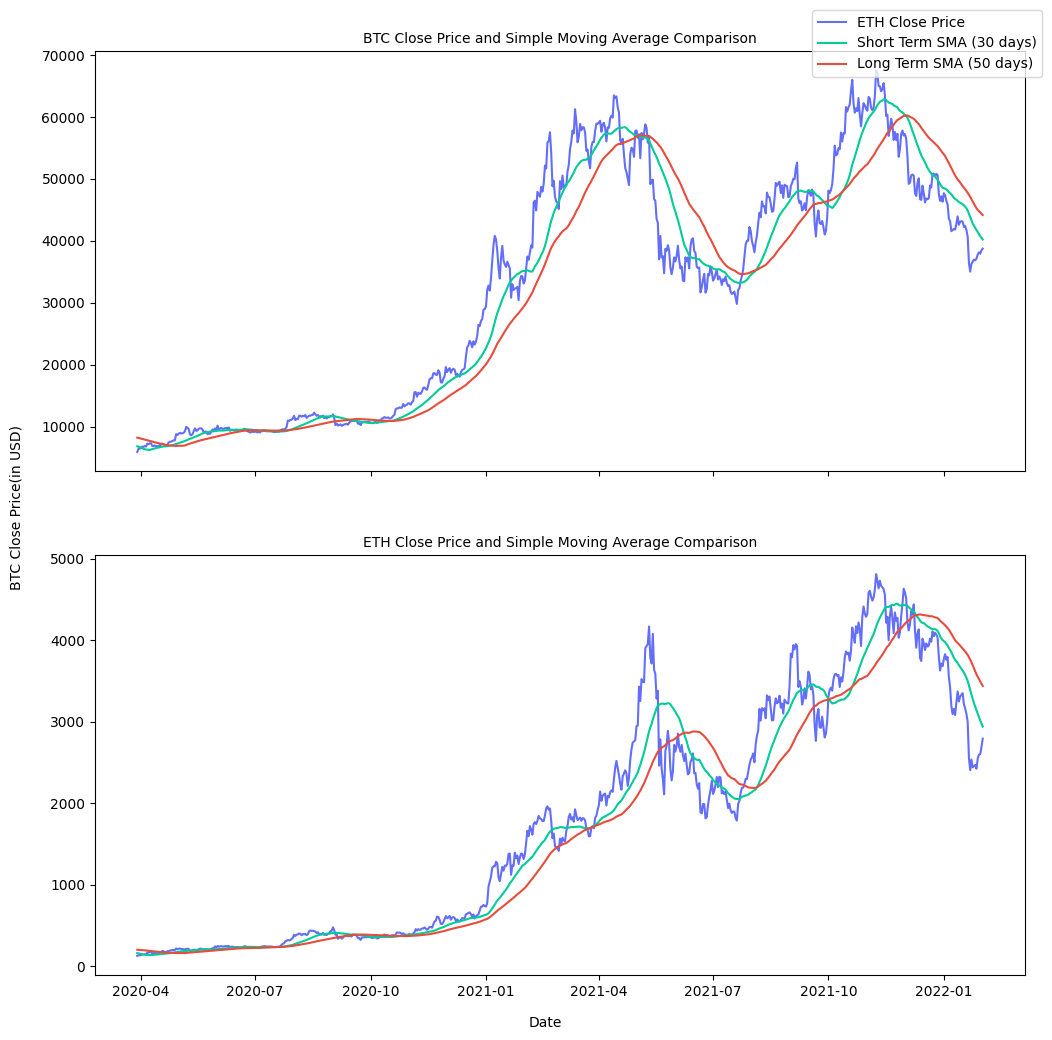

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
ax1, ax2 = axes.flatten()
BTC_colour = {"BTC_close": "#636EFA", "BTC_close_"+str(window1): "#00CC96", "BTC_close_"+str(window2): "#E74C3C"}
ETH_colour = {"ETH_close": "#636EFA", "ETH_close_"+str(window1): "#00CC96", "ETH_close_"+str(window2): "#E74C3C"}

BTC_close, = ax1.plot(df_btceth_ma['BTC_close'], c=BTC_colour['BTC_close'])
BTC_close_a, = ax1.plot(df_btceth_ma['BTC_close_'+str(window1)], c=BTC_colour['BTC_close_'+str(window1)])
BTC_close_b, = ax1.plot(df_btceth_ma['BTC_close_'+str(window2)], c=BTC_colour['BTC_close_'+str(window2)])
ax1.set_title('BTC Close Price and Simple Moving Average Comparison')
ax1.title.set_size(10)

ETH_close, = ax2.plot(df_btceth_ma['ETH_close'], c=ETH_colour['ETH_close'])
ETH_close_a, = ax2.plot(df_btceth_ma['ETH_close_'+str(window1)], c=ETH_colour['ETH_close_'+str(window1)])
ETH_close_b, = ax2.plot(df_btceth_ma['ETH_close_'+str(window2)], c=ETH_colour['ETH_close_'+str(window2)])
ax2.set_title('ETH Close Price and Simple Moving Average Comparison')
ax2.title.set_size(10)

fig.legend((ETH_close, ETH_close_a, ETH_close_b), ('ETH Close Price', 'Short Term SMA (30 days)', 'Long Term SMA (50 days)'), loc='upper right', bbox_to_anchor=[0.92, 0.92])

# Set common labels
fig.text(0.5, 0.07, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'BTC Close Price(in USD)', ha='center', va='center', rotation='vertical')

plt.show()


In [54]:
def dualMACrossover(data, asset):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1 # Flag denoting when the 2 moving averages crossed each other
    for i in range(len(data)):
        if data[asset+'_close_'+str(window1)][i] > data[asset+'_close_'+str(window2)][i]:
            if flag != 1:
                sigPriceBuy.append(data[asset+'_close'][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data[asset+'_close_'+str(window1)][i] < data[asset+'_close_'+str(window2)][i]:
            if flag!=0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data[asset+'_close'][i])
                flag=0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy,sigPriceSell)

In [55]:
buy_sell = dualMACrossover(df_btceth_ma, 'BTC')
df_btceth_ma['BTC_BuySignalPrice'] = buy_sell[0]
df_btceth_ma['BTC_SellSignalPrice'] = buy_sell[1]

buy_sell = dualMACrossover(df_btceth_ma, 'ETH')
df_btceth_ma['ETH_BuySignalPrice'] = buy_sell[0]
df_btceth_ma['ETH_SellSignalPrice'] = buy_sell[1]

In [56]:
df_btceth_ma

,BTC_close,ETH_close,BTC_units,ETH_units,Portfolio_Val,Portfolio_Val_With_Straddle,original_log_return,log_return,BTC_close_28,BTC_close_56,ETH_close_28,ETH_close_56,BTC_BuySignalPrice,BTC_SellSignalPrice,ETH_BuySignalPrice,ETH_SellSignalPrice
Date,,,,,,,,,,,,,,,,
2020-03-29,5922.042969,125.583733,10.701636,0.000000,63375.551150,63375.551150,-0.052650,-0.052650,6841.805682,8226.548506,160.221244,201.014397,NaN,5922.042969,NaN,125.583733
2020-03-30,6429.841797,132.904541,10.701636,0.000000,68809.829620,68809.829620,0.082268,0.082268,6754.668963,8175.411368,156.733200,199.997245,NaN,NaN,NaN,NaN
2020-03-31,6438.644531,133.593567,10.701636,0.000000,68904.033284,68904.033284,0.001368,0.001368,6670.771048,8126.441398,153.487269,199.003369,NaN,NaN,NaN,NaN
2020-04-01,6606.776367,135.634552,10.701636,0.000000,70703.319075,70703.319075,0.025778,0.025778,6594.039987,8072.751264,150.312861,197.778446,NaN,NaN,NaN,NaN
2020-04-02,6793.624512,142.029144,10.701636,0.000000,72702.899997,72702.899997,0.027889,0.027889,6512.427909,8020.319528,147.197181,196.522912,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,37784.332031,2547.092041,10.665089,56.690538,547369.285120,567033.132365,0.026218,0.025297,41428.863839,44997.531808,3100.195644,3551.312435,NaN,NaN,NaN,NaN
2022-01-29,38138.179688,2597.084717,10.212899,63.330947,553977.213574,573641.060819,0.012000,0.011586,41087.841239,44799.986747,3058.316633,3524.124887,NaN,NaN,NaN,NaN
2022-01-30,37917.601562,2603.466553,10.246770,62.837648,552128.639166,571792.486411,-0.003342,-0.003228,40751.140625,44595.500209,3014.527405,3495.645312,NaN,NaN,NaN,NaN


In [57]:
fig = px.line(df_btceth_ma, y="BTC_close", title='BTC Strategy Visualization')
fig.add_scatter(x=df_btceth_ma.index, y=df_btceth_ma['BTC_close_'+str(window1)], mode='lines', name='BTC_close_'+str(window1), line_color='#00CC96')
fig.add_scatter(x=df_btceth_ma.index, y=df_btceth_ma['BTC_close_'+str(window2)], mode='lines', name='BTC_close_'+str(window2), line_color='#E74C3C')

fig.add_trace(go.Scatter(mode="markers", x=df_btceth_ma.index, y=df_btceth_ma.BTC_BuySignalPrice, marker_symbol='triangle-up',
                           marker_line_color="#00CC96", marker_color="#00CC96", 
                           marker_line_width=2, marker_size=10, name='Buy'))

fig.add_trace(go.Scatter(mode="markers", x=df_btceth_ma.index, y=df_btceth_ma.BTC_SellSignalPrice, marker_symbol='triangle-down',
                           marker_line_color="#E74C3C", marker_color="#E74C3C", 
                           marker_line_width=2, marker_size=10, name='Sell'))
fig.show()

In [58]:
fig = px.line(df_btceth_ma, y="ETH_close", title='ETH Strategy Visualization')
fig.add_scatter(x=df_btceth_ma.index, y=df_btceth_ma['ETH_close_'+str(window1)], mode='lines', name='ETH_close_'+str(window1), line_color='#00CC96')
fig.add_scatter(x=df_btceth_ma.index, y=df_btceth_ma['ETH_close_'+str(window2)], mode='lines', name='ETH_close_'+str(window2), line_color='#E74C3C')

fig.add_trace(go.Scatter(mode="markers", x=df_btceth_ma.index, y=df_btceth_ma.ETH_BuySignalPrice, marker_symbol='triangle-up',
                           marker_line_color="#00CC96", marker_color="#00CC96", 
                           marker_line_width=2, marker_size=10, name='Buy'))

fig.add_trace(go.Scatter(mode="markers", x=df_btceth_ma.index, y=df_btceth_ma.ETH_SellSignalPrice, marker_symbol='triangle-down',
                           marker_line_color="#E74C3C", marker_color="#E74C3C", 
                           marker_line_width=2, marker_size=10, name='Sell'))
fig.show()

In [59]:
df_btceth_ma['Portfolio_Val_with_dma'] = df_btceth_ma['Portfolio_Val']
BTC_bearish = False
BTC_put_bought = []
ETH_bearish = False
ETH_put_bought = []

for i in range(df_btceth_ma.shape[0]):
    if not math.isnan(df_btceth_ma['BTC_BuySignalPrice'][i]):
        BTC_bearish = False
    if not math.isnan(df_btceth_ma['ETH_BuySignalPrice'][i]):
        ETH_bearish = False
    if BTC_bearish and BTC_put_bought and pd.to_datetime(df_btceth_ma.index[i]) == pd.to_datetime(BTC_put_bought[-1]):
        curr_date = pd.to_datetime(df_btceth_ma.index[i])
        print("BTC bear: ", curr_date)
        nearest_date = options.loc[(pd.to_datetime(options['exercise_date']) > curr_date)]['exercise_date'].iloc[0].strftime('%Y-%m-%d')
        temp = options.loc[(options['exercise_date']==nearest_date) & (options['coin_type']=='BTC') & (options['option_type']=='P') & (options['side']=='buy')]
        BTC_put_bought.append(nearest_date)
        putstobuy = deepcopy(temp)
        if len(putstobuy) > 0 and pd.to_datetime(nearest_date) < pd.to_datetime(df_btceth_ma.tail(1).index[0]):
            currprice = df_btceth_ma['BTC_close'][i]
            diff = currprice - 0.25*putstobuy['strike_price'].astype(int).std() - putstobuy['strike_price'].astype(int) # 1 std away from the current price as strike price
            putstobuy['abs_diff'] = diff.abs()
            putstobuy = putstobuy.sort_values('abs_diff', ascending=True)
            idealsp = int(putstobuy.iloc[0]['strike_price'])
            putstobuy = putstobuy.loc[putstobuy['strike_price'].astype(int) == idealsp]
            putstobuy = putstobuy.sort_values('price', ascending=True)
            strikeprice = putstobuy.iloc[0, 7]
            exercisedate = putstobuy.iloc[0, 6]
            btc_exerciseprice = df_btceth_ma.loc[exercisedate, 'BTC_close']
            num_options = int(round(df_btceth_ma['BTC_units'][i]))
            options_cost = float(putstobuy.iloc[0]['price'])*num_options
            # num_options, options_cost = market_order_on_options(num_options, putstobuy)

            additional_return = max(float(strikeprice) - btc_exerciseprice, 0)*num_options - options_cost*currprice
            print('BTC exercise day price: ', btc_exerciseprice, ', BTC strike price: ', strikeprice)
            print("BTC bear return: ", additional_return)
            print("option payoff is: ", max(float(strikeprice) - btc_exerciseprice, 0)*num_options, "cost is: ", options_cost)
            df_btceth_ma.loc[exercisedate:, 'Portfolio_Val_with_dma'] += additional_return

    if ETH_bearish and ETH_put_bought and pd.to_datetime(df_btceth_ma.index[i]) == pd.to_datetime(BTC_put_bought[-1]):
        curr_date = pd.to_datetime(df_btceth_ma.index[i])
        print("ETH bear: ", curr_date)
        nearest_date = options.loc[(pd.to_datetime(options['exercise_date']) > curr_date)]['exercise_date'].iloc[0].strftime('%Y-%m-%d')
        ETH_put_bought.append(nearest_date)
        temp = options.loc[(options['exercise_date']==nearest_date) & (options['coin_type']=='ETH') & (options['option_type']=='P') & (options['side']=='buy')]
        putstobuy = deepcopy(temp)
        if len(putstobuy) > 0 and pd.to_datetime(nearest_date) < pd.to_datetime(df_btceth_ma.tail(1).index[0]):
            currprice = df_btceth_ma['ETH_close'][i]
            diff = currprice - 0.25*putstobuy['strike_price'].astype(int).std() - putstobuy['strike_price'].astype(int) # 1 std away from the current price as strike price
            putstobuy['abs_diff'] = diff.abs()
            putstobuy = putstobuy.sort_values('abs_diff', ascending=True)
            idealsp = int(putstobuy.iloc[0]['strike_price'])
            putstobuy = putstobuy.loc[putstobuy['strike_price'].astype(int) == idealsp]
            putstobuy = putstobuy.sort_values('price', ascending=True)
            strikeprice = putstobuy.iloc[0, 7]
            exercisedate = putstobuy.iloc[0, 6]
            eth_exerciseprice = df_btceth_ma.loc[exercisedate, 'ETH_close']
            num_options = int(round(df_btceth_ma['ETH_units'][i]))
            options_cost = float(putstobuy.iloc[0]['price'])*num_options
            # num_options, options_cost = market_order_on_options(num_options, putstobuy)

            additional_return = max(float(strikeprice) - eth_exerciseprice, 0)*num_options - options_cost*currprice
            print('ETH exercise day price: ', eth_exerciseprice, ', ETH strike price: ', strikeprice)
            print("ETH bear return: ", additional_return)
            print("option payoff is: ", max(float(strikeprice) - eth_exerciseprice, 0)*num_options, ", cost is: ", options_cost)
            df_btceth_ma.loc[exercisedate:, 'Portfolio_Val_with_dma'] += additional_return

    if not math.isnan(df_btceth_ma['BTC_SellSignalPrice'][i]):
        BTC_bearish = True
        nearest_date = options.loc[(pd.to_datetime(options['exercise_date']) > pd.to_datetime(df_btceth_ma.index[i]))]['exercise_date'].iloc[0].strftime('%Y-%m-%d')
        BTC_put_bought.append(nearest_date)
        temp = options.loc[(options['exercise_date']==nearest_date) & (options['coin_type']=='BTC') & (options['option_type']=='P') & (options['side']=='buy')]
        putstobuy = deepcopy(temp)
        if len(putstobuy) > 0 and pd.to_datetime(nearest_date) < pd.to_datetime(df_btceth_ma.tail(1).index[0]):
            currprice = df_btceth_ma['BTC_close'][i]
            diff = currprice - 0.25*putstobuy['strike_price'].astype(int).std() - putstobuy['strike_price'].astype(int) # 1 std away from the current price as strike price
            putstobuy['abs_diff'] = diff.abs()
            putstobuy = putstobuy.sort_values('abs_diff', ascending=True)
            idealsp = int(putstobuy.iloc[0]['strike_price'])
            putstobuy = putstobuy.loc[putstobuy['strike_price'].astype(int) == idealsp]
            putstobuy = putstobuy.sort_values('price', ascending=True)
            strikeprice = putstobuy.iloc[0, 7]
            exercisedate = putstobuy.iloc[0, 6]
            btc_exerciseprice = df_btceth_ma.loc[exercisedate, 'BTC_close']
            num_options = int(round(df_btceth_ma['BTC_units'][i]))
            options_cost = float(putstobuy.iloc[0]['price'])*num_options
            # num_options, options_cost = market_order_on_options(num_options, putstobuy)

            additional_return = max(float(strikeprice) - btc_exerciseprice, 0)*num_options - options_cost*currprice
            print('BTC exercise day price: ', btc_exerciseprice, ', BTC strike price: ', strikeprice)
            print("BTC bear return: ", additional_return)
            print("option payoff is: ", max(float(strikeprice) - btc_exerciseprice, 0)*num_options, "cost is: ", options_cost)
            df_btceth_ma.loc[exercisedate:, 'Portfolio_Val_with_dma'] += additional_return

    if not math.isnan(df_btceth_ma['ETH_SellSignalPrice'][i]):
        ETH_bearish = True
        nearest_date = options.loc[(pd.to_datetime(options['exercise_date']) > pd.to_datetime(df_btceth_ma.index[i]))]['exercise_date'].iloc[0].strftime('%Y-%m-%d')
        ETH_put_bought.append(nearest_date)
        temp = options.loc[(options['exercise_date']==nearest_date) & (options['coin_type']=='ETH') & (options['option_type']=='P') & (options['side']=='buy')]
        putstobuy = deepcopy(temp)
        if len(putstobuy) > 0 and pd.to_datetime(nearest_date) < pd.to_datetime(df_btceth_ma.tail(1).index[0]):
            currprice = df_btceth_ma['ETH_close'][i]
            diff = currprice - 0.25*putstobuy['strike_price'].astype(int).std() - putstobuy['strike_price'].astype(int) # 1 std away from the current price as strike price
            putstobuy['abs_diff'] = diff.abs()
            putstobuy = putstobuy.sort_values('abs_diff', ascending=True)
            idealsp = int(putstobuy.iloc[0]['strike_price'])
            putstobuy = putstobuy.loc[putstobuy['strike_price'].astype(int) == idealsp]
            putstobuy = putstobuy.sort_values('price', ascending=True)
            strikeprice = putstobuy.iloc[0, 7]
            exercisedate = putstobuy.iloc[0, 6]
            eth_exerciseprice = df_btceth_ma.loc[exercisedate, 'ETH_close']
            num_options = int(round(df_btceth_ma['ETH_units'][i]))
            options_cost = float(putstobuy.iloc[0]['price'])*num_options
            # num_options, options_cost = market_order_on_options(num_options, putstobuy)

            additional_return = max(float(strikeprice) - eth_exerciseprice, 0)*num_options - options_cost*currprice
            print('ETH exercise day price: ', eth_exerciseprice, ', ETH strike price: ', strikeprice)
            print("ETH bear return: ", additional_return)
            print("option payoff is: ", max(float(strikeprice) - eth_exerciseprice, 0)*num_options, ", cost is: ", options_cost)
            df_btceth_ma.loc[exercisedate:, 'Portfolio_Val_with_dma'] += additional_return

BTC exercise day price:  6733.38720703125 , BTC strike price:  5750
BTC bear return:  -130.28494531249999
option payoff is:  0 cost is:  0.022
BTC bear:  2020-04-03 00:00:00
BTC exercise day price:  6865.4931640625 , BTC strike price:  6500
BTC bear return:  -4295.901038085937
option payoff is:  0 cost is:  0.638
BTC bear:  2020-04-10 00:00:00
BTC exercise day price:  8864.7666015625 , BTC strike price:  6500
BTC bear return:  -37.76021240234375
option payoff is:  0 cost is:  0.0055
BTC exercise day price:  9278.8076171875 , BTC strike price:  9000
BTC bear return:  -2195.894056640625
option payoff is:  0 cost is:  0.242
BTC bear:  2020-07-10 00:00:00
BTC exercise day price:  11759.5927734375 , BTC strike price:  10000
BTC bear return:  -153.10032568359375
option payoff is:  0 cost is:  0.0165
ETH exercise day price:  385.19970703125 , ETH strike price:  300
ETH bear return:  -5.512876281738281
option payoff is:  0 , cost is:  0.0225
BTC exercise day price:  10692.716796875 , BTC strik

In [60]:
df_btceth_ma

,BTC_close,ETH_close,BTC_units,ETH_units,Portfolio_Val,Portfolio_Val_With_Straddle,original_log_return,log_return,BTC_close_28,BTC_close_56,ETH_close_28,ETH_close_56,BTC_BuySignalPrice,BTC_SellSignalPrice,ETH_BuySignalPrice,ETH_SellSignalPrice,Portfolio_Val_with_dma
Date,,,,,,,,,,,,,,,,,
2020-03-29,5922.042969,125.583733,10.701636,0.000000,63375.551150,63375.551150,-0.052650,-0.052650,6841.805682,8226.548506,160.221244,201.014397,NaN,5922.042969,NaN,125.583733,63375.551150
2020-03-30,6429.841797,132.904541,10.701636,0.000000,68809.829620,68809.829620,0.082268,0.082268,6754.668963,8175.411368,156.733200,199.997245,NaN,NaN,NaN,NaN,68809.829620
2020-03-31,6438.644531,133.593567,10.701636,0.000000,68904.033284,68904.033284,0.001368,0.001368,6670.771048,8126.441398,153.487269,199.003369,NaN,NaN,NaN,NaN,68904.033284
2020-04-01,6606.776367,135.634552,10.701636,0.000000,70703.319075,70703.319075,0.025778,0.025778,6594.039987,8072.751264,150.312861,197.778446,NaN,NaN,NaN,NaN,70703.319075
2020-04-02,6793.624512,142.029144,10.701636,0.000000,72702.899997,72702.899997,0.027889,0.027889,6512.427909,8020.319528,147.197181,196.522912,NaN,NaN,NaN,NaN,72702.899997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,37784.332031,2547.092041,10.665089,56.690538,547369.285120,567033.132365,0.026218,0.025297,41428.863839,44997.531808,3100.195644,3551.312435,NaN,NaN,NaN,NaN,474001.934518
2022-01-29,38138.179688,2597.084717,10.212899,63.330947,553977.213574,573641.060819,0.012000,0.011586,41087.841239,44799.986747,3058.316633,3524.124887,NaN,NaN,NaN,NaN,480609.862972
2022-01-30,37917.601562,2603.466553,10.246770,62.837648,552128.639166,571792.486411,-0.003342,-0.003228,40751.140625,44595.500209,3014.527405,3495.645312,NaN,NaN,NaN,NaN,478761.288564


In [61]:
df_btceth_ma['new_log_return'] = np.log(df_btceth_ma['Portfolio_Val_with_dma'] / df_btceth_ma['Portfolio_Val_with_dma'].shift(1))
df_btceth_ma = df_btceth_ma.iloc[1:]

cumulative_return = df_btceth_ma['new_log_return'].sum()
annualized_return = np.exp(cumulative_return * (365 / len(df_btceth_ma))) - 1
cumulative_return_ori = df_btceth_ma['original_log_return'].sum()
annualized_return_ori = np.exp(cumulative_return_ori * (365 / len(df_btceth_ma))) - 1
print(f'Annualized return for our portfolio originally is {annualized_return_ori*100:.2f}%')
print(f'Annualized return for our portfolio with double moving average strategy is {annualized_return*100:.2f}%')

Annualized return for our portfolio originally is 229.34%
Annualized return for our portfolio with double moving average strategy is 205.77%


In [62]:
mean_daily_returns = df_btceth_ma['new_log_return'].mean()
std_daily_returns = df_btceth_ma['new_log_return'].std()

mean_daily_returns_ori = df_btceth_ma['original_log_return'].mean()
std_daily_returns_ori = df_btceth_ma['original_log_return'].std()

annualized_mean_returns = mean_daily_returns * 365
annualized_std_returns = std_daily_returns * np.sqrt(365)

annualized_mean_returns_ori = mean_daily_returns_ori * 365
annualized_std_returns_ori = std_daily_returns_ori * np.sqrt(365)

sharpe_ratio = round((annualized_mean_returns) / annualized_std_returns, 3)
sharpe_ratio_ori = round((annualized_mean_returns_ori) / annualized_std_returns_ori, 3)

print(f'Annualized Sharpe ratio for our portfolio originally is {sharpe_ratio_ori}.')
print(f'Annualized Sharpe ratio for our portfolio using Double Simple Moving Average is {sharpe_ratio}.')

Annualized Sharpe ratio for our portfolio originally is 1.543.
Annualized Sharpe ratio for our portfolio using Double Simple Moving Average is 1.36.


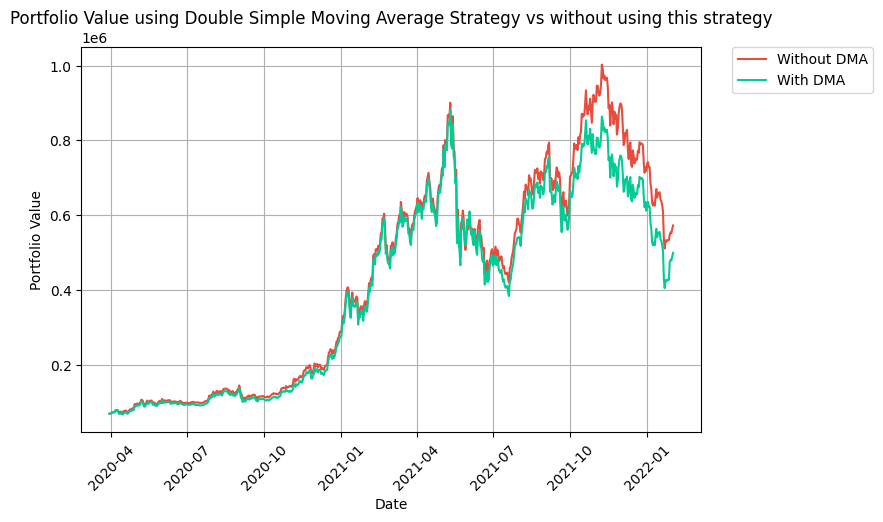

In [63]:
plt.figure(figsize=(8,5))
plt.plot(df_btceth_ma["Portfolio_Val"], c="#E74C3C", label='Without DMA')
plt.plot(df_btceth_ma["Portfolio_Val_with_dma"], c="#00CC96", label='With DMA')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Portfolio Value using Double Simple Moving Average Strategy vs without using this strategy')
plt.show()